# Determine sRGB section in xyY space for specific Y value

I'm trying to determine the outline of the sRGB cube in a Y-slice of the xyY colorspace.

## Requirements

for my fresh Miniconda3 Install:
```
conda create -n sRGB_Y_section_in_xyY_space python=3.9 numpy sympy networkx trimesh
activate sRGB_Y_section_in_xyY_space
conda install -c conda-forge colour-science trimesh
conda install -n sRGB_Y_section_in_xyY_space ipykernel --update-deps
```

## Goal Description

When transformed to the xyY colorspace the RGB cube changes its shape:

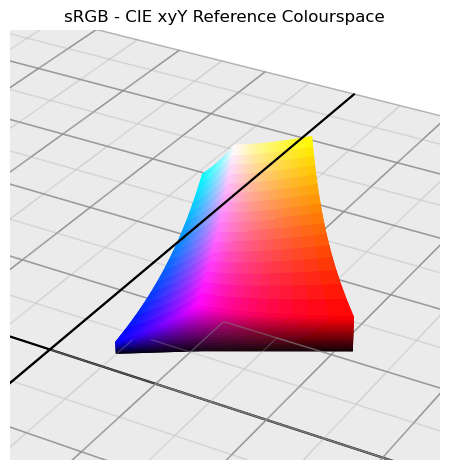

In [1]:
import colour
from colour.plotting import plot_RGB_colourspaces_gamuts

with colour.utilities.suppress_warnings(colour_usage_warnings=True):
    plot_RGB_colourspaces_gamuts('sRGB', 'CIE xyY',segments=16)

Better Visualization on Wikipedia: https://en.wikipedia.org/wiki/File:SRGB_gamut_within_CIExyY_color_space_mesh.webm

I want to analytically calculate the shape of the section for a specific $Y$ value

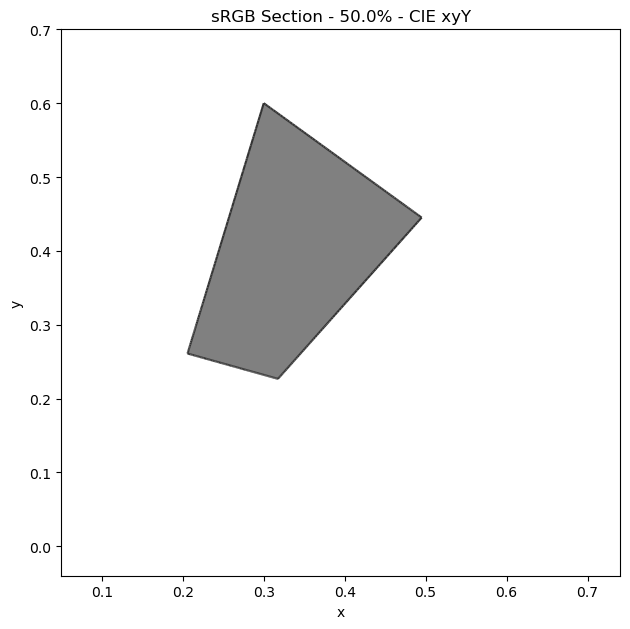

In [2]:
from colour.plotting import plot_RGB_colourspace_section

with colour.utilities.suppress_warnings(colour_usage_warnings=True):
    plot_RGB_colourspace_section('sRGB', 'CIE xyY', Y = 0.3)

## Determining the transformation
We determine the $rgb$ to $xyY$ transformation using `sympy`

First we transform $rgb$ to $XYZ$

In [3]:
import sympy
from sympy import Matrix, Eq

sRGB = colour.models.rgb.RGB_COLOURSPACE_sRGB
r, g, b, Y = sympy.symbols('r g b Y', real=True, positive=True)
v_rgb = Matrix([[r], [g], [b]])

# From colour.sRGB_to_XYZ
matrix_RGB_to_XYZ = Matrix(sRGB.matrix_RGB_to_XYZ)

from colour import xyY_to_XYZ, xy_to_xyY
from colour.adaptation import matrix_chromatic_adaptation_VonKries

M_CAT = matrix_chromatic_adaptation_VonKries(
    xyY_to_XYZ(xy_to_xyY(sRGB.whitepoint)),
    xyY_to_XYZ(xy_to_xyY(sRGB.whitepoint)),
    transform="CAT02",
)
M_CAT = Matrix(M_CAT)


v_xyz = matrix_RGB_to_XYZ * v_rgb
v_xyz = M_CAT * v_xyz
v_xyz

Matrix([
[0.1805*b + 0.3576*g + 0.4124*r],
[0.0722*b + 0.7152*g + 0.2126*r],
[0.9505*b + 0.1192*g + 0.0193*r]])

Then we transform $XYZ$ to $xy$ for fixed $Y$

In [4]:
v_xyY = Matrix([
    [v_xyz[0] / (v_xyz[0] + v_xyz[1] + v_xyz[2])],
    [Y / (v_xyz[0] + v_xyz[1] + v_xyz[2])],
    [Y]
])

#v_xyY = v_xyY.subs(v_xyz[1], Y) #Maybe replace the Y value?

#We only care about xy, because Y will be given
v_xy = v_xyY[0:2,0]
v_xy

Matrix([
[(0.1805*b + 0.3576*g + 0.4124*r)/(1.2032*b + 1.192*g + 0.6443*r)],
[                               Y/(1.2032*b + 1.192*g + 0.6443*r)]])

In [5]:
Eq(v_xyz[1],Y)

Eq(0.0722*b + 0.7152*g + 0.2126*r, Y)

## Calculate intersections of $RGB$-Cube in $xyY$ with $Y$-Plane

We calculate the intersections between all 6 sides of the $RGB$-Cube ($r=0,r=1,g=0,g=1,b=0,b=1$).
Then we use the previous $Y$ equation to replace one of the remaining variables.

First we list all possible combinations:

In [6]:
variations = [
    ((b,0), g, r), #Read as: set b=0, solve for g, remaining variable is r
        ((b,0), r, g),
    ((b,1), g, r),
        ((b,1), r, g),

    ((r,0), g, b),
        ((r,0), b, g),
    ((r,1), g, b),
        ((r,1), b, g),

    ((g,0), r, b),
        ((g,0), b, r),
    ((g,1), r, b),
        ((g,1), b, r),
]

In [7]:
from sympy import Max, Min, cancel, together, solve

results = {}
for side_sub, solve_for, unsolved_for in variations:
    v_xy_side = v_xy.subs([side_sub])
    solve_eq = Eq(v_xyz[1],Y).subs([side_sub])
    solved_for_var = solve(solve_eq, solve_for)
    if (solved_for_var):
        f = v_xy_side.subs(solve_for, solved_for_var[0])
        f0 = solve(Eq(solved_for_var[0], 0), unsolved_for)
        f1 = solve(Eq(solved_for_var[0], 1), unsolved_for)

        min_other_var = together(cancel(Min(f0[0], f1[0])))
        max_other_var = together(cancel(Max(f0[0], f1[0])))

        # Solution is only valid if other var is between 0 and 1
        condition = (min_other_var <= 1) & (max_other_var >= 0)

        clamp0 = Max(0, min_other_var)
        clamp1 = Min(1, max_other_var)

        p1 = together(f.subs(unsolved_for, clamp0))
        p2 = together(f.subs(unsolved_for, clamp1))

        results[(side_sub, solve_for)] = [
             p1, p2, condition
        ]

We now have 8 pairs of points that are corner points of the section - if the condition is valid.

Example solutions for $r=0$ side, solved for $b$:

In [8]:
from IPython.display import display, Latex

display(Latex("$$f(0) = {}$$".format(sympy.printing.latex(results[((r,0), b)][0]))))
display(Latex("$$f(1) = {}$$".format(sympy.printing.latex(results[((r,0), b)][1]))))
display(Latex("$$ {}$$".format(sympy.printing.latex(results[((r,0), b)][2]))))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Show solutions for different $Y$ values

Shown alongside the `plot_RGB_colourspace_section` result from the `colour` module, which uses a mesh-intersection algorithm to get the same result

Y = 0.3:
(b, 0), g: (0.300000000000000, 0.600000000000000) - (0.577366133592135, 0.379762859192371)
(b, 0), r: (0.577366133592134, 0.379762859192371) - (0.299999999999999, 0.600000000000001)
(b, 1), g: (0.185991660699996, 0.189529545550267) - (0.320637180742191, 0.160185102785441)
(b, 1), r: (0.320637180742191, 0.160185102785441) - (0.185991660699995, 0.189529545550267)
(r, 0), g: (0.300000000000000, 0.600000000000000) - (0.185991660699996, 0.189529545550267)
(r, 0), b: (0.185991660699996, 0.189529545550268) - (0.300000000000003, 0.600000000000009)
(r, 1), g: (0.577366133592135, 0.379762859192371) - (0.320637180742191, 0.160185102785441)
(r, 1), b: (0.320637180742192, 0.160185102785442) - (0.577366133592139, 0.379762859192375)
(g, 0), r: Skipping! Outside interval
(g, 0), b: Skipping! Outside interval
(g, 1), r: Skipping! Outside interval
(g, 1), b: Skipping! Outside interval
Y = 0.5:
(b, 0), g: (0.300000000000000, 0.600000000000000) - (0.495059200569750, 0.445117065788302)
(b, 0), r: 

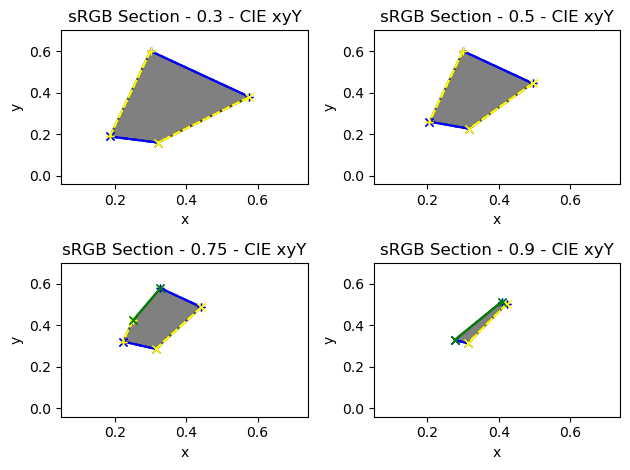

In [9]:
import matplotlib.pyplot as plt

Ys = [0.3, 0.5, 0.75, 0.9]
fig, axs = plt.subplots(2,2)

markers = {0: '+', 1:'x'}
colors = {b: 'blue', g: 'green', r:'yellow'}
linestyles = {r: 'solid', g: 'dashed', b: 'dotted'}

for Yset, ax in zip(Ys, axs.flat):
    print(f"Y = {Yset}:")
    plot_RGB_colourspace_section('sRGB', 'CIE xyY', origin=Yset, normalise=False, standalone=False, axes=ax)

    for (side_sub, solve_for),(p1, p2, condition) in results.items():
        print(f"{side_sub}, {solve_for}: ", end="")
        if not condition.subs(Y, Yset):
            print("Skipping! Outside interval")
            continue
        x1, y1 = p1.subs(Y, Yset)
        x2, y2 = p2.subs(Y, Yset)
        print(f"({x1}, {y1}) - ({x2}, {y2})")
        ax.plot([x1,x2],[y1,y2], label=f"{side_sub}, {solve_for}",
            marker = markers[side_sub[1]], color=colors[side_sub[0]],
            linestyle=linestyles[solve_for]
        )
plt.show()

### Table showing results

From the text output it can be seen, that there are a lot of overlapping results.

For example the result for $f_{b=0,g}(0)$ is equal to $f_{b=0,r}(1)$.

These are the sets that grant equal results. Not all functions are valid for the whole $Y$-range, so the marked functions were selected to create a good coverage.

In [10]:
from sympy import Piecewise, oo

axes = {"x": 0, "y": 1}

allsets = [
    [
        ((b,0),g,0), ((b,0),r,1),
        ((r,0),g,0), ((r,0),b,1),
        ((g,1),r,0), ((g,1),b,1),
    ],
    [
        ((b,0),r,0), ((b,0),g,1),
        ((g,0),r,0), ((g,0),b,1),
        ((r,1),g,0), ((r,1),b,1),
    ],
    [
        ((b,1),r,0), ((b,1),g,1),
        ((g,0),b,0), ((g,0),r,1),
        ((r,1),b,0), ((r,1),g,1),
    ],
    [
        ((b,1),g,0), ((b,1),r,1),
        ((r,0),b,0), ((r,0),g,1),
        ((g,1),b,0), ((g,1),r,1),
    ],
]

selectedsets = [
    {
        ((b,0),g,0), ((g,1),r,0), 
    },
    {
        ((b,0),r,0), ((r,1),b,1),
    },
    {
        ((b,1),g,1), ((g,0),b,0),
    },
    {
        ((b,1),g,0), ((r,0),b,0), 
    },
]


Ys = [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99,1]
table_output = ["<table><tbody>"]
for i, (equalsets, selectedset) in enumerate(zip(allsets,selectedsets), 1):
    if i > 1:
        table_output.append(f'<tr><th colspan="{len(Ys) + 1}">&nbsp;</th></tr>')
    table_output.append(f'<tr><th>Set {i}</th>')
    table_output.extend(f'<th>{Yset}</th>' for Yset in Ys)
    table_output.append('</tr>')
    for axisname, axis in axes.items():
        for s in equalsets:
            side_sub, solve_for, pnum = s
            if s in selectedset:
                table_output.append('<tr style="background-color: yellow;color: black">')
            else:
                table_output.append('<tr>')
            table_output.append(f'<th>{s}</th>')
            condition = results[(side_sub, solve_for)][2]
            for Yset in Ys:
                f = results[(side_sub, solve_for)][pnum][axis]
                f = Piecewise((f, condition), (oo, True))
                value = float(f.subs(Y, Yset))
                table_output.append(f'<td>{value:12.9f}</td>')
            table_output.append('</tr>')
table_output.append('</tbody></table>')
from IPython.display import HTML, display
display(HTML(''.join(table_output)))

Set 1,0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,1
"((b, 0), g, 0)",nan,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.360315454,0.408706221,inf,inf
"((b, 0), r, 1)",nan,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.360315454,0.408706221,inf,inf
"((r, 0), g, 0)",nan,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,inf,inf,inf,inf
"((r, 0), b, 1)",nan,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,0.300000000,inf,inf,inf,inf
"((g, 1), r, 0)",inf,inf,inf,inf,inf,inf,inf,inf,inf,0.360315454,0.408706221,0.322153757,inf
"((g, 1), b, 1)",inf,inf,inf,inf,inf,inf,inf,inf,inf,0.360315454,0.408706221,0.322153757,inf
"((b, 0), g, 0)",nan,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.552107696,0.513683956,inf,inf
"((b, 0), r, 1)",nan,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.552107696,0.513683956,inf,inf
"((r, 0), g, 0)",nan,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,inf,inf,inf,inf
"((r, 0), b, 1)",nan,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,0.600000000,inf,inf,inf,inf


Sadly I don't know of a better way to do this instead of the manual sorting and guessing. If you know: Let me know.

## Resulting points
We combine the selected points into function for each point. Moving the Pointwise into the vector, so the codegenerator can understand it.

In [11]:
def generate_functions_for_set(s):
    axes = {"x", "y"}
    result = []
    for i, equalset in enumerate(s):
        fs = Matrix([
            [sympy.piecewise_exclusive(
                Piecewise(*[
                        (results[(side_sub, solve_for)][pnum][axis], results[(side_sub, solve_for)][2])
                        for side_sub, solve_for, pnum in equalset
                    ], (oo, True)
                )
            )] for axis in range(2)
        ])
        #Readd the "otherwise" case that was removed by piecewise_exclusive
        fs = Matrix([
            [Piecewise(*fs[axis].args,(oo, True))]
            for axis in range(2)
        ])
        display(Latex(f'$$p_{i} = {sympy.printing.latex(fs)}$$'))
        result.append(fs)
    return result
point_functions = generate_functions_for_set(selectedsets)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Generated code 

In [12]:
from sympy import MatrixSymbol
p_mat_sym = MatrixSymbol('p', 2, 1)
for i, pf in enumerate(point_functions):
    code = sympy.jscode(pf, assign_to=p_mat_sym)
    display(HTML(f'<pre>{code}</pre>'))


As an alternative to the manual selection one could also just use all the functions and let `sympy.piecewise_exclusive` do the job. That does not get rid of manually grouping the functions into groups, though:

In [13]:
point_functions_unfiltered = generate_functions_for_set(allsets)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [14]:
for i, pf in enumerate(point_functions_unfiltered):
    display(HTML(f'<pre>{sympy.jscode(pf, assign_to=p_mat_sym)}</pre>'))